In [1]:
import datetime
import logging
import os
import numpy as np 
import tensorflow as tf
from tensorflow.keras import activations
from tensorflow.keras import callbacks
from tensorflow.keras import layers
from tensorflow.keras import models

from tensorflow import feature_column as fc

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import keras

In [3]:
import numpy as np

In [4]:
from tensorflow.keras.callbacks import EarlyStopping

In [220]:
from tensorflow.keras.backend import clear_session

In [386]:
!pwd

/Users/yanchunyang/Documents/training/learning_datasets


In [81]:
!cp ~/Downloads/ltv_train.csv ~/Documents/training/learning_datasets/

In [82]:
!ls

loss_arrival.csv           ltv_train_64.csv
lossrate_disbursement.csv  new_ltv_training.csv
lr_time_series_model.ipynb optuna.db
ltv_predict.csv            taxi-train.csv
ltv_tf_version.ipynb       taxi-valid.csv
ltv_tf_version_2.ipynb     taxifare.ipynb
ltv_train.csv


In [85]:
df_raw = pd.read_csv("ltv_train.csv")

In [86]:
df_raw.shape

(952418, 85)

In [90]:
columns = df_raw.columns

In [93]:
df_raw['forecast_date'] = pd.to_datetime(df_raw['OBSERVATION_TS'])

In [94]:
types = {item[0]: item[1] for item in zip(df_raw.dtypes.index, df_raw.dtypes)}

In [95]:
columns_select = df_raw.columns[3:-7]

In [96]:
cat_columns = [item for item in columns_select if types[item] == 'object']

In [97]:
num_columns = [item for item in columns_select if types[item] != 'object']

In [98]:
y = df_raw.loc[:, ['LABEL_REVENUE_6M']].fillna(0).values.astype(np.float32)

In [99]:
df = df_raw[num_columns + cat_columns]

In [100]:
len(y)

952418

In [101]:
def get_dataset(num_feature, categorical_feature, labels):
    length = linear_features.shape[0]
    train_cat_linear, train_num_linear, train_label = categorical_feature[0:int(0.8*length)], num_feature[0:int(0.8*length)], labels[0:int(0.8*length)]
    test_cat_linear, test_num_linear, test_label = categorical_feature[int(0.8*length):], num_feature[0:int(0.8*length)], labels[int(0.8*length):]
    return train_linear, train_num_linear, train_label, test_cat_linear, test_num_linear, test_label

In [102]:
print(tf.__version__)

2.16.1


In [103]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [105]:
#write a pipeline

def get_pipeline_update(df, num_columns, cat_columns):
    categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    numerical_transformer = StandardScaler()
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, num_columns),
            ('cat', categorical_transformer, cat_columns)
            ]
    )
    preprocessor.fit(df)
    return preprocessor

In [106]:
preprocess = get_pipeline_update(df, num_columns, cat_columns)

In [107]:
df.loc[df['ADVANCE_LAST_6M_COUNT']>0,:].shape

(952418, 76)

In [108]:
transformed_data = preprocess.transform(df)

In [109]:
transformed_data.shape

(952418, 241)

In [110]:
categorical_feature_df = preprocess.named_transformers_['cat'].get_feature_names_out(cat_columns)

In [111]:
all_feature_names = np.concatenate([num_columns, categorical_feature_df])

In [112]:
transformed_df = pd.DataFrame(transformed_data, columns=all_feature_names)

In [113]:
transformed_df=transformed_df.fillna(0)

In [114]:
def capped_linear(x, cap_value=2000.0):
    return tf.keras.backend.minimum(x, cap_value)

In [237]:
def get_model(shape):
    input_dense = tf.keras.Input(shape=(shape, ), name='input_dense')
    dense_output = layers.Dense(256, activation='relu')(input_dense)
    dense_output = layers.Dropout(rate=0.2)(dense_output)
    dense_output = layers.Dense(128, activation='relu')(dense_output)  
    dense_output = layers.Dropout(rate=0.2)(dense_output)
    dense_output = layers.Dense(64, activation='relu')(dense_output)
    output = layers.Dense(1, activation='linear')(dense_output)
    capped_output = layers.Lambda(lambda x: capped_linear(x, cap_value=2000))(output)
    model = models.Model(inputs=input_dense, outputs=capped_output)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    return model
                  
    

In [211]:
inputs_value = transformed_df.values
outputs = y

In [117]:
def split_train(length, r1):
    shuffle_index = np.random.permutation(length)
    test_size = int(length * r1)
    test_index = shuffle_index[:test_size]
    train_index = shuffle_index[test_size:]
    return test_index, train_index

In [118]:
length = inputs_value.shape[0]

In [191]:
test_index, train_index = split_train(length, 0.25)

In [192]:
train_inputs, test_inputs = inputs_value[train_index], inputs_value[test_index]

In [193]:
train_outputs, test_outputs = y[train_index], y[test_index]

In [194]:
train_inputs.shape

(714314, 241)

In [238]:
clear_session()

In [239]:
model_tf = get_model(transformed_df.shape[1])

In [240]:
early_stopping = EarlyStopping(
    monitor='mean_squared_error',  # Metric to monitor
    mode='min',
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Verbosity mode
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

In [241]:
history_np = model_tf.fit(
    train_inputs, train_outputs, 
    epochs=40, batch_size=32, 
    validation_split=0.2,
    callbacks=[early_stopping]    
)

Epoch 1/40
17858/17858 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - loss: 3387.2195 - mean_squared_error: 3387.2195 - val_loss: 3146.7861 - val_mean_squared_error: 3146.7861
Epoch 2/40
17858/17858 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - loss: 3192.7209 - mean_squared_error: 3192.7209 - val_loss: 3138.5273 - val_mean_squared_error: 3138.5273
Epoch 3/40
17858/17858 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - loss: 3149.4487 - mean_squared_error: 3149.4487 - val_loss: 3050.6816 - val_mean_squared_error: 3050.6816
Epoch 4/40
17858/17858 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - loss: 3135.1528 - mean_squared_error: 3135.1528 - val_loss: 3097.3113 - val_mean_squared_error: 3097.3113
Epoch 5/40
17858/17858 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - loss: 3100.5996 - mean_squared_error: 3100.5996 - val_loss: 3318.1462 - val_mean_squared_error: 3318.1462
Epoch 6/40
17858/17858 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - loss: 3079.6699 - mean_squared_error: 3079.6699 - val_loss: 3113.8145 - val_mean_squared_error: 3113.8145
Epoch 7/40

In [52]:
train_inputs.shape

(619120, 234)

In [242]:
test_pred = model_tf.predict(test_inputs)

7441/7441 ━━━━━━━━━━━━━━━━━━━━ 3s 360us/step


In [243]:
np.squeeze(test_pred).mean()

43.51294

In [244]:
test_outputs.mean()

51.33396

In [6]:
prediction = pd.read_csv("ltv_predict.csv")

In [7]:
checkcol = zip(df.columns, prediction.columns)

In [32]:
prediction[num_columns] = prediction[num_columns].astype(float)

In [33]:
prediction[cat_columns] = prediction[cat_columns].astype(str)

In [129]:
pred_tf = prediction[num_columns + cat_columns]

In [130]:
transformed_predict = preprocess.transform(pred_tf)

In [131]:
t1 = np.nan_to_num(transformed_predict, nan=0.0)

In [132]:
t1.shape

(2044901, 241)

In [245]:
predicted_value = model_tf.predict(t1)

63904/63904 ━━━━━━━━━━━━━━━━━━━━ 22s 340us/step


In [246]:
predicted = predicted_value.squeeze()

In [247]:
predicted[predicted<2500].mean()

56.20777

In [201]:
min(predicted)

-17.294666

(array([1.820536e+06, 1.712680e+05, 4.997200e+04, 2.901000e+03,
        1.280000e+02, 2.300000e+01, 9.000000e+00, 0.000000e+00,
        0.000000e+00, 6.400000e+01]),
 array([ -17.29466629,  167.61750793,  352.52966309,  537.4418335 ,
         722.35400391,  907.26617432, 1092.17834473, 1277.09057617,
        1462.00268555, 1646.91491699, 1831.82702637]),
 <BarContainer object of 10 artists>)

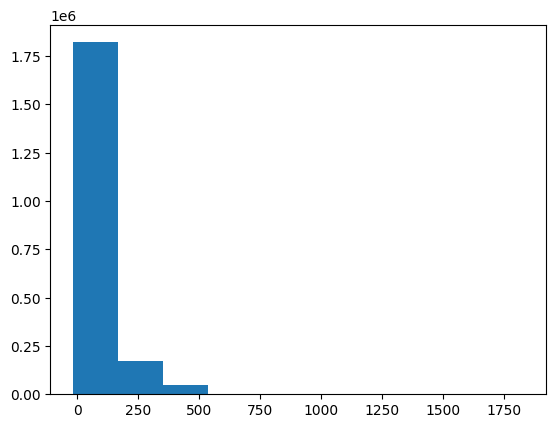

In [202]:
plt.hist(predicted)

In [58]:
inputs_predict = model_tf.predict(inputs_value)

24185/24185 ━━━━━━━━━━━━━━━━━━━━ 6s 255us/step


In [59]:
inputs_predict.mean()

40.510204

In [60]:
outputs.mean()

44.496925

In [107]:
!pwd

/Users/yanchunyang/Documents/training/learning_datasets


In [183]:
inputs_value.shape

(2000014, 275)

In [69]:
prediction[prediction['ADVANCE_LAST_6M_AMOUNT_TOTAL']>0].shape

(1933526, 86)

In [553]:
y_churn[0:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [66]:
from tensorflow.keras.losses import BinaryCrossentropy

In [65]:
def get_churn_model(shape):
    input_dense = tf.keras.Input(shape=(shape, ), name='input_dense')
    dense_output = layers.Dense(100, activation='relu')(input_dense)
    dense_output = layers.Dropout(rate=0.2)(dense_output)
    dense_output = layers.Dense(20, activation='relu')(dense_output)  
    dense_output = layers.Dropout(rate=0.2)(dense_output)
    dense_output = layers.Dense(5, activation='relu')(dense_output)
    output = layers.Dense(1, activation='sigmoid')(dense_output)
    capped_output = layers.Lambda(lambda x: capped_linear(x, cap_value=2000))(output)
    model = models.Model(inputs=input_dense, outputs=capped_output)
    model.compile(loss=BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])
    return model
                  

In [138]:
y_churn = df_raw.loc[:, ['LABEL_RETENTION_6M']].fillna(0).values.astype(np.float32)
inputs_value = transformed_df.values
outputs = y_churn
train_inputs_churn, test_inputs_churn = inputs_value[train_index], inputs_value[test_index]
train_outputs_churn, test_outputs_churn = y_churn[train_index], y_churn[test_index]

In [139]:
model_tf_churn = get_churn_model(transformed_df.shape[1])
early_stopping_churn = EarlyStopping(
    monitor='accuracy',  # Metric to monitor
    mode='max',
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Verbosity mode
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)
history_np_churn = model_tf_churn.fit(
    train_inputs_churn, train_outputs_churn, 
    epochs=30, batch_size=32, 
    validation_split=0.1,
    callbacks=[early_stopping_churn]    
)

Epoch 1/30
21430/21430 ━━━━━━━━━━━━━━━━━━━━ 14s 615us/step - accuracy: 0.8745 - loss: 0.2815 - val_accuracy: 0.8866 - val_loss: 0.2515
Epoch 2/30
21430/21430 ━━━━━━━━━━━━━━━━━━━━ 13s 623us/step - accuracy: 0.8865 - loss: 0.2527 - val_accuracy: 0.8883 - val_loss: 0.2494
Epoch 3/30
21430/21430 ━━━━━━━━━━━━━━━━━━━━ 13s 624us/step - accuracy: 0.8878 - loss: 0.2489 - val_accuracy: 0.8883 - val_loss: 0.2485
Epoch 4/30
21430/21430 ━━━━━━━━━━━━━━━━━━━━ 12s 575us/step - accuracy: 0.8884 - loss: 0.2475 - val_accuracy: 0.8892 - val_loss: 0.2498
Epoch 5/30
21430/21430 ━━━━━━━━━━━━━━━━━━━━ 12s 548us/step - accuracy: 0.8897 - loss: 0.2443 - val_accuracy: 0.8871 - val_loss: 0.2482
Epoch 6/30
21430/21430 ━━━━━━━━━━━━━━━━━━━━ 12s 547us/step - accuracy: 0.8894 - loss: 0.2441 - val_accuracy: 0.8886 - val_loss: 0.2449
Epoch 7/30
21430/21430 ━━━━━━━━━━━━━━━━━━━━ 12s 562us/step - accuracy: 0.8898 - loss: 0.2429 - val_accuracy: 0.8876 - val_loss: 0.2444
Epoch 8/30
21430/21430 ━━━━━━━━━━━━━━━━━━━━ 12s 552us/s

In [140]:
predicted_value = model_tf_churn.predict(t1)
predicted = predicted_value.squeeze()
predicted[predicted<2500].mean()

63904/63904 ━━━━━━━━━━━━━━━━━━━━ 17s 263us/step


0.53691226

In [141]:
test_pred = model_tf_churn.predict(test_inputs_churn)
test_pred = test_pred.squeeze()
test_pred.mean()

5953/5953 ━━━━━━━━━━━━━━━━━━━━ 2s 260us/step


0.6164202

In [142]:
test_outputs_churn.mean()

0.6338781

In [143]:
66/0.46

143.47826086956522

<h3> xgboost model </h3>

In [157]:
import xgboost as xgb

In [325]:
np.random.seed(42)

In [149]:
def split_train_test(length, r1, r2):
    shuffle_index = np.random.permutation(length)
    test_size = int(length * r1)
    valid_size = int(length * r2)
    print(test_size)
    print(valid_size)
    test_index = shuffle_index[:test_size]
    valid_index = shuffle_index[test_size: valid_size]
    train_index = shuffle_index[valid_size:]
    return test_index, valid_index, train_index

In [144]:
df_xg = df_raw.copy()

In [145]:
df_xg[cat_columns] = df_xg[cat_columns].astype('category')

In [146]:
X_COL = cat_columns + num_columns

In [147]:
Y_COL = 'LABEL_REVENUE_6M'

In [150]:
test_index, valid_index, train_index = split_train_test(df_xg.shape[0], 0.2, 0.4)

190483
380967


In [151]:
valid_index.shape

(190484,)

In [152]:
train = df_xg.iloc[train_index]
val = df_xg.iloc[valid_index]
test = df_xg.iloc[test_index]

In [153]:
test.shape

(190483, 86)

In [154]:
val.shape

(190484, 86)

In [174]:
Y_COL

'LABEL_REVENUE_6M'

In [158]:
dtrain = xgb.DMatrix(train[X_COL], label=train[Y_COL], enable_categorical=True)
dvalid = xgb.DMatrix(val[X_COL], label=val[Y_COL], enable_categorical=True)
dtest = xgb.DMatrix(test[X_COL], label=test[Y_COL], enable_categorical=True)

In [248]:
import xgboost as xgb
import optuna
from optuna import Trial
from optuna.samplers import TPESampler, QMCSampler
from sklearn.metrics import root_mean_squared_error


def train_model(dtrain, dvalid, num_boost_round, params):
    return xgb.train(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=[(dvalid, "valid")],
        verbose_eval=False,
        early_stopping_rounds=100,
    )


def objective(trial: Trial, dtrain, dvalid):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.8, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    }
    num_boost_round = trial.suggest_int("num_boost_round", 100, 1000)
    model = train_model(dtrain, dvalid, num_boost_round, params)
    preds = model.predict(dvalid)
    score = root_mean_squared_error(dvalid.get_label(), preds)
    return score


sampler = QMCSampler(seed=42)
study = optuna.create_study(
    direction="minimize", sampler=sampler, storage="sqlite:///optuna.db"
)
study.optimize(lambda trial: objective(trial, dtrain, dvalid), n_trials=60)

best_params = study.best_params

best_params

/var/folders/d1/rw6rwxz927g254dvggnj0jpr0000gn/T/ipykernel_86949/206844803.py:33: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler = QMCSampler(seed=42)
[I 2024-06-07 10:46:10,726] A new study created in RDB with name: no-name-0fb7e9a7-0cab-4fb7-8967-12182aafea29
[I 2024-06-07 10:46:14,073] Trial 0 finished with value: 57.25820541381836 and parameters: {'max_depth': 5, 'learning_rate': 0.7969454818643931, 'subsample': 0.9463987883622811, 'colsample_bytree': 0.7993292420985183, 'num_boost_round': 240}. Best is trial 0 with value: 57.25820541381836.
[I 2024-06-07 10:46:15,794] Trial 1 finished with value: 63.403194427490234 and parameters: {'max_depth': 3, 'learning_rate': 0.010000000000000005, 'subsample': 0.8, 'colsample_bytree': 0.5, 'num_boost_round': 100}. Best is trial 0 with value: 57.25820541381836.
[I 2024-06-07 10:46:25,336] Trial 2 finished with value: 54.67042922973633 and parameters: {'max_depth': 7, '

{'max_depth': 10,
 'learning_rate': 0.022067340690845903,
 'subsample': 0.896875,
 'colsample_bytree': 0.5390625,
 'num_boost_round': 311}

In [249]:
model = train_model(
    dtrain, dvalid, study.best_trial.params["num_boost_round"], best_params
)

/Users/yanchunyang/Documents/virenv/tensorflow/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:11:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)


In [164]:
prediction.shape

(2044901, 86)

In [250]:
predict_data = prediction.copy()

In [252]:
predict_data[cat_columns] =  predict_data[cat_columns].astype('category')

In [253]:
pred =  xgb.DMatrix(predict_data[X_COL], enable_categorical=True)

In [254]:
predicted_value = model.predict(pred)

In [255]:
predicted_value.mean()

83.24114

In [256]:
predicted_value[predicted_value <2500].mean()

83.24114

In [257]:
max(predicted_value)

1130.9604

In [173]:
predicted_value[predicted_value < 1000].mean()

90.5286

(array([1.601458e+06, 3.467610e+05, 7.791700e+04, 1.345400e+04,
        3.642000e+03, 1.272000e+03, 2.370000e+02, 5.800000e+01,
        2.900000e+01, 7.300000e+01]),
 array([-146.98077393,  349.18643188,  845.3536377 , 1341.52087402,
        1837.68811035, 2333.85522461, 2830.02246094, 3326.18969727,
        3822.35693359, 4318.52441406, 4814.69140625]),
 <BarContainer object of 10 artists>)

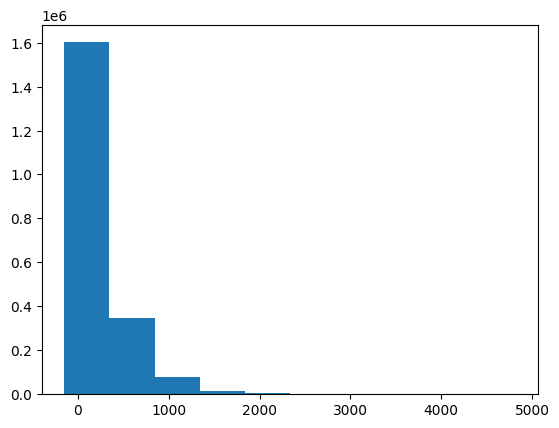

In [347]:
plt.hist(predicted_value)

In [165]:
predicted_value.mean()

235.39156

In [348]:
train_predict = model.predict(dtrain)

In [349]:
train_predict.mean()

36.45143

(array([8.91968e+05, 3.01865e+05, 5.60200e+03, 4.64000e+02, 7.10000e+01,
        2.30000e+01, 5.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+01]),
 array([-589.06182861,   14.96037006,  618.98254395, 1223.00476074,
        1827.02697754, 2431.04907227, 3035.07128906, 3639.09350586,
        4243.11572266, 4847.13818359, 5451.16015625]),
 <BarContainer object of 10 artists>)

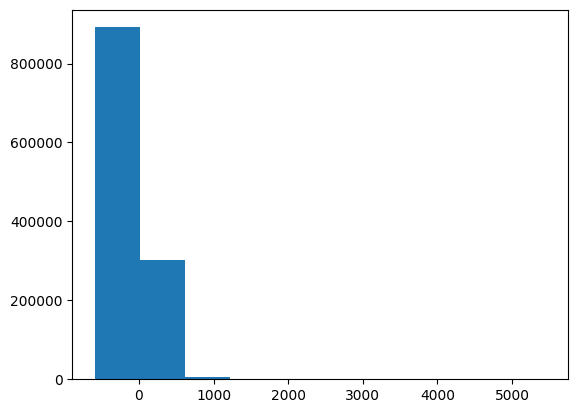

In [350]:
plt.hist(train_predict)

In [258]:
predict_test = model.predict(dtest)

In [259]:
predict_test.mean()

51.432686

In [260]:
Y_COL

'LABEL_REVENUE_6M'

In [261]:
test[Y_COL].mean()

51.51537082049316

In [175]:
Y_COL_CHURN = 'LABEL_RETENTION_6M'

In [176]:
dtrain_churn = xgb.DMatrix(train[X_COL], label=train[Y_COL_CHURN], enable_categorical=True)
dvalid_churn = xgb.DMatrix(val[X_COL], label=val[Y_COL_CHURN], enable_categorical=True)
dtest_churn = xgb.DMatrix(test[X_COL], label=test[Y_COL_CHURN], enable_categorical=True)

In [179]:
from sklearn.metrics import log_loss, roc_auc_score

In [183]:
def log_loss_metric(y_true, y_pred):
    return log_loss(y_true, y_pred)
    
def train_model_churn(dtrain, dvalid, num_boost_round, params):
    return xgb.train(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=[(dvalid, "valid")],
        verbose_eval=False,
        early_stopping_rounds=100,
    )


def objective_churn(trial: Trial, dtrain, dvalid):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.8, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "objective": "binary:logistic",
        "eval_metric": "logloss"
    }
    num_boost_round = trial.suggest_int("num_boost_round", 100, 1000)
    model = train_model(dtrain, dvalid, num_boost_round, params)
    preds = model.predict(dvalid)
    score = log_loss_metric(dvalid.get_label(), preds)
    return score


sampler = QMCSampler(seed=42)
study_churn = optuna.create_study(
    direction="minimize", sampler=sampler, storage="sqlite:///optuna.db"
)
study_churn.optimize(lambda trial: objective_churn(trial, dtrain_churn, dvalid_churn), n_trials=50)

best_params_churn = study_churn.best_params

best_params_churn

/var/folders/d1/rw6rwxz927g254dvggnj0jpr0000gn/T/ipykernel_86949/273311208.py:31: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler = QMCSampler(seed=42)
[I 2024-06-05 23:31:33,283] A new study created in RDB with name: no-name-128744d8-0815-4c71-9b2e-95ddfb95f138
[I 2024-06-05 23:31:37,923] Trial 0 finished with value: 0.24844181198326817 and parameters: {'max_depth': 5, 'learning_rate': 0.7969454818643931, 'subsample': 0.9463987883622811, 'colsample_bytree': 0.7993292420985183, 'num_boost_round': 240}. Best is trial 0 with value: 0.24844181198326817.
[I 2024-06-05 23:31:40,074] Trial 1 finished with value: 0.4056075953716903 and parameters: {'max_depth': 3, 'learning_rate': 0.010000000000000005, 'subsample': 0.8, 'colsample_bytree': 0.5, 'num_boost_round': 100}. Best is trial 0 with value: 0.24844181198326817.
[I 2024-06-05 23:31:56,897] Trial 2 finished with value: 0.23247677422910235 and parameters: {'max_dept

{'max_depth': 9,
 'learning_rate': 0.0316227766016838,
 'subsample': 0.8500000000000001,
 'colsample_bytree': 0.625,
 'num_boost_round': 775}

In [184]:
model_churn = train_model_churn(
    dtrain_churn, dvalid_churn, study.best_trial.params["num_boost_round"], best_params_churn
)

/Users/yanchunyang/Documents/virenv/tensorflow/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:44:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)


In [185]:
predicted_value_churn = model_churn.predict(pred)

In [186]:
predicted_value_churn.mean()

0.5669477

In [187]:
90/0.43

209.30232558139537

<h3> check distribution </h3>

In [72]:
t1.shape

(2044901, 234)

In [73]:
train_inputs.shape

(619120, 234)

In [74]:
np.mean(t1[:,1])

0.44314576257763916

In [77]:
prediction['USER_AGE'].mean()

683.1934533750044

In [78]:
df['USER_AGE'].mean()

330.4436645561442

In [75]:
for i in range(0, 234):
    print(str(np.mean(t1[:,i])) + '\t' + str(np.mean(train_inputs[:,i])))

0.9560511382642192	-7.310912751795798e-05
0.44314576257763916	7.760387161067956e-05
0.046602606797265134	-0.0004136621257682883
1.059345608664897	-0.0006255920728262575
0.6792580415250961	0.000199139164821841
0.8763445733302153	0.00024308741031195486
0.45157810600774867	-0.0006793301431774691
0.8067610500869177	0.00035713113352211405
0.5467620910424197	2.2519325801352116e-05
-0.05877387333481839	-0.00022453966096054335
-0.18636983132251878	-0.0002015275637037973
1.0409367409133865	0.0005945721943573118
0.1811024317644599	-0.00035272444004508886
1.4482583819125263	0.0009816671041660721
0.6778179499932337	0.00046005057899134796
0.06162152966799439	-0.0003376761905940961
-0.0036863793042796324	-0.0005614232513645499
0.2967626448331659	-0.000733314562289785
-0.29824177649351635	0.0006890265875838587
0.06316019762247	2.1542679216639554e-05
0.2699623785009984	-0.00046631797844768583
0.3894023597616902	-0.0006644499700986072
0.8763407812314129	0.00024956447626396216
0.2610902916589603	0.00034

KeyboardInterrupt: 

In [76]:
transformed_df.columns

Index(['USER_AGE', 'BOD_ACCOUNT_OPEN', 'BOD_DIRECT_DEPOSIT',
       'DAYS_SINCE_PERCENTAGE_BASED_PRICING', 'ADVANCE_LIFETIME_COUNT',
       'ADVANCE_LIFETIME_AMOUNT_TOTAL', 'ADVANCE_LIFETIME_AMOUNT_MEAN',
       'ADVANCE_LIFETIME_AMOUNT_RANGE', 'ADVANCE_LIFETIME_AMOUNT_STDDEV',
       'ADVANCE_LIFETIME_AMOUNT_SLOPE',
       ...
       'APPROVAL_REJECTION_REASON_MODE_payday-today',
       'APPROVAL_REJECTION_REASON_MODE_predicted-upcoming-income',
       'APPROVAL_REJECTION_REASON_MODE_stale-income',
       'APPROVAL_REJECTION_REASON_MODE_nan',
       'BANK_CONNECTION_HAS_VALID_CREDENTIALS_False',
       'BANK_CONNECTION_HAS_VALID_CREDENTIALS_True',
       'BANK_CONNECTION_HAS_VALID_CREDENTIALS_nan',
       'BANK_CONNECTION_HAS_TRANSACTIONS_False',
       'BANK_CONNECTION_HAS_TRANSACTIONS_True',
       'BANK_CONNECTION_HAS_TRANSACTIONS_nan'],
      dtype='object', length=234)

In [80]:
for item in num_columns:
    print(str(item) + '\t' + str(df[item].mean()) + '\t' + str(prediction[item].mean()))

USER_AGE	330.4436645561442	683.1934533750044
BOD_ACCOUNT_OPEN	0.7640483266571908	0.9522045321509452
BOD_DIRECT_DEPOSIT	0.03582762630830857	0.04448919532045806
DAYS_SINCE_PERCENTAGE_BASED_PRICING	-290.7823814446311	274.0
ADVANCE_LIFETIME_COUNT	12.207000904509627	23.642284394207838
ADVANCE_LIFETIME_AMOUNT_TOTAL	1330.7235623077916	3374.660830939981
ADVANCE_LIFETIME_AMOUNT_MEAN	92.66892774982134	122.40855997109382
ADVANCE_LIFETIME_AMOUNT_RANGE	84.4173430675798	166.21053493054185
ADVANCE_LIFETIME_AMOUNT_STDDEV	36.573366211790606	56.54563813808434
ADVANCE_LIFETIME_AMOUNT_SLOPE	0.23747438346293298	0.11335032559385881
ADVANCE_LIFETIME_TIP_PERCENT_MEAN	0.04371966199081277	0.03445372715306512
ADVANCE_LIFETIME_REVENUE_TOTAL	112.66348267667999	279.64836577418646
ADVANCE_LIFETIME_REVENUE_MEAN	13.143415841528213	17.029863157389308
ADVANCE_LIFETIME_REVENUE_RANGE	19.943895947662426	79.33272547668567
ADVANCE_LIFETIME_REVENUE_STDDEV	8.698096457161531	21.315651565564245
ADVANCE_LIFETIME_REVENUE_SLOPE	0.2